# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [38]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal
import utils

In [39]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib ipympl
import matplotlib.pyplot as plt

In [40]:
datadir = "./"

im1_file = datadir + 'nutmeg.jpg'
im2_file = datadir + 'DerekPicture.jpg'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

#### Get Eye Points

In [41]:
# pts_im1 = utils.prompt_eye_selection(im1)
pts_im1 = np.array([[607, 290], [748, 370]]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')

In [42]:
# pts_im2 = utils.prompt_eye_selection(im2)
pts_im2 = np.array([[299,343], [439,331]]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')

In [43]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

In [44]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

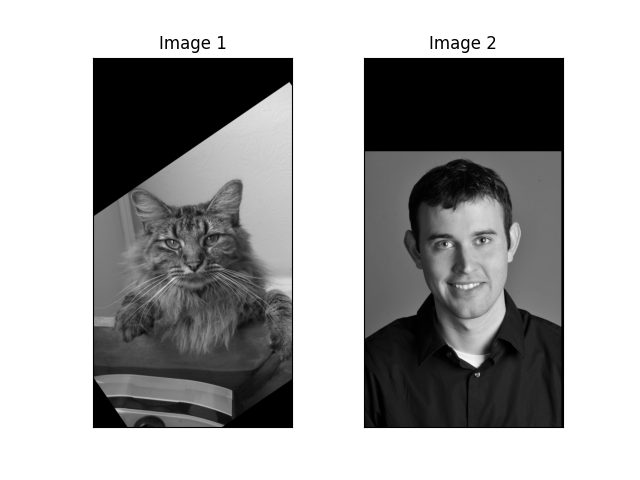

In [45]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

In [ ]:
def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  

    fig, ax = plt.subplots(3, 1)

    # Take FFT of image
    im2_fft = np.abs(np.fft.fftshift(np.fft.fft2(im2)))
    # Plot the spectrum
    plt_mappable = ax[0].imshow(im2_fft, norm=LogNorm(vmin=1/5))
    fig.colorbar(plt_mappable)
    print(f"fft img shape: {im2_fft.shape}")

    # Create gaussian kernel in frequency space
    ksize = int(np.ceil(sigma_low)*6+1)
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low) # 1D kernel
    gauss_kernel = gauss_kernel*np.transpose(gauss_kernel) # 2D kernel by outer product
    # Pad kernel to make it same shape as fft image
    rows_to_add = im2_fft.shape[0] - gauss_kernel.shape[0]
    cols_to_add = im2_fft.shape[1] - gauss_kernel.shape[1]
    # I did +1 because the shape was one off from fft_img shape in both dimensions
    padded_gauss = np.pad(gauss_kernel, ((rows_to_add//2, rows_to_add//2 +1), (cols_to_add//2, cols_to_add//2 +1)), mode='constant', constant_values=0)
    ax[1].imshow(padded_gauss, cmap='gray') 
    print(f"padded gauss shape: {padded_gauss.shape}")

    # Apply filter to fft_img
    # TODO ELC pick up from here, the picture output looks wrong
    # TODO ELC Maybe switch to dft from opencv2, not fft from numpy..?
    fft_filtered = im2_fft * padded_gauss
    ax[2].imshow(fft_filtered, cmap='gray')

    # Undo original shift
    fft_filtered_unshifted = np.fft.ifftshift(fft_filtered)
    # Inverse the fft
    inverse_fft_filtered = np.real(np.fft.ifft2(fft_filtered_unshifted))
    # ax[2].imshow(inverse_fft_filtered, cmap='gray')
    print(f"Final low-pass image shape: {padded_gauss.shape}")


fft img shape: (1374, 738)
padded gauss shape: (1374, 738)
Final low-pass image shape: (1374, 738)


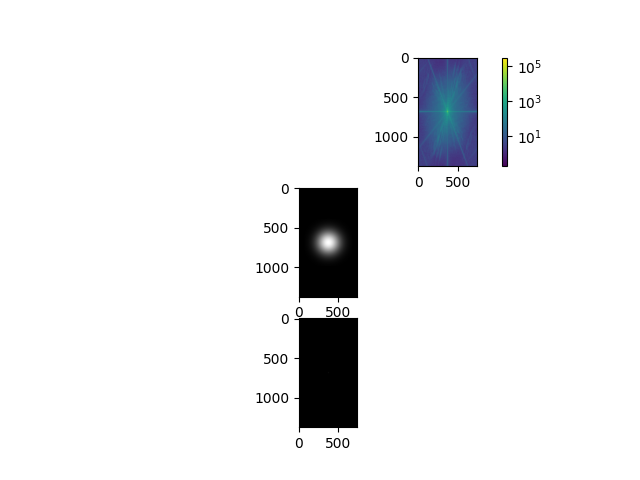

In [78]:
sigma_low = 100 # choose parameters that work for your images
sigma_high = 20

im_hybrid = hybridImage(im2, im1, sigma_low, sigma_high)


In [ ]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

#### Color enhancement 

#### Color shift